In [2]:
### Initial Value Problem of ODE type:
# u'(t) = F(t,u) in T
# u(t0) = u0

In [3]:
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from torch.nn.parameter import Parameter
from torchvision.datasets import MNIST
from timeit import default_timer as tdt

from softadapt import SoftAdapt, NormalizedSoftAdapt, LossWeightedSoftAdapt

if torch.cuda.is_available():
    my_device = 'cuda'
else:
    my_device = 'cpu'

C:\Users\seeb\AppData\Local\anaconda3\envs\deep_learning_1\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
def F(u, lambd):
    return lambd * u
def u(t, lambd, u0):
    return u0 * torch.exp(lambd*t)

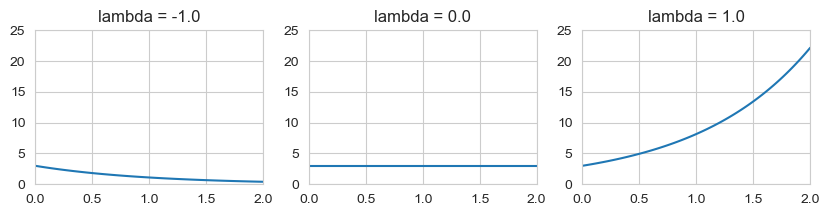

In [5]:
u0 = 3.0
t_lin = torch.linspace(0, 2, 100)
# Solution with lambda = -1.0
u_minus1 = u(t_lin, -1.0, u0)
# Solution with lambda = 0.0
u_plus05 = u(t_lin, 0.0, u0)
# Solution with lambda = 1.0
u_plus1 = u(t_lin, 1.0, u0)

fig, ax = plt.subplots(1,3, figsize=(10,2))
ax[0].plot(t_lin, u_minus1)
ax[0].set_title('lambda = -1.0')
ax[1].plot(t_lin, u_plus05)
ax[1].set_title('lambda = 0.0')
ax[2].plot(t_lin, u_plus1)
ax[2].set_title('lambda = 1.0')

for i in range(3):
    ax[i].set_xlim(0.0, 2.0)
    ax[i].set_ylim(0, 25)


In [6]:
# Define loss functions
# Use torches MSE loss.
torch_MSE_loss = torch.nn.MSELoss()

def loss_ODE(t, lambd, F, net):
    # Combining to network parameter
    t_lambd = torch.concatenate((t, lambd), axis=1)
    
    # Calculate u from the network
    u_net = net(t_lambd)

    # Take gradient of network w.r.t. the input t. This is u'(t)
    lhs = torch.autograd.grad(u_net, t_lambd, grad_outputs=torch.ones_like(u_net), create_graph=True)[0]
    # We only want the derivative w.r.t. t which is the first columns. I think
    lhs = lhs[:,0].view(-1,1)
    
    # The other term is F(t,u)
    rhs = F(u_net, lambd)
    
    # Calculate the MSE of the residual
    loss_ODE = torch_MSE_loss(rhs, lhs)

    return loss_ODE
    
def loss_IC(t0, lambd, u0, net):
    t0 = t0.view(-1,1)
    lambd = lambd.view(-1,1)
    t_lambd = torch.concatenate((t0, lambd), axis=1)
    
    # Get network response to initial condition
    u0_net = net(t_lambd)

    u0 = torch.ones_like(u0_net) * u0
    # Compare to initial condition WE choose
    loss_IC = torch_MSE_loss(u0_net, u0)

    return loss_IC

In [7]:
# Define network
class FFN(nn.Module):
    def __init__(self, input_size, hidden_layers_size, output_size):
        super(FFN, self).__init__()
        
        n_layers = len(hidden_layers_size)
        HL = hidden_layers_size
        
        # Define layers
        self.L1 = nn.Linear(input_size, HL[0], bias=True)
        self.L2 = nn.Linear(HL[0], HL[1], bias=True)
        self.L3 = nn.Linear(HL[1], HL[2], bias=True)
        #self.L4 = nn.Linear(HL[2], HL[3], bias=True)
        #self.L5 = nn.Linear(HL[3], HL[4], bias=True)
        self.output = nn.Linear(HL[-1], output_size, bias=True)
        
        # Define activation function
        self.act_fn = nn.Tanh()

    def forward(self, x):
        # Hidden layers
        x = self.act_fn(self.L1(x))
        x = self.act_fn(self.L2(x))
        x = self.act_fn(self.L3(x))
        #x = self.act_fn(self.L4(x))
        #x = self.act_fn(self.L5(x))
        
        # Output layer
        x = self.output(x)
        
        return x

# Define network
net = FFN(2, [64, 64, 64], 1).to(my_device)

# Print Network shape
print()
print(net.parameters)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



<bound method Module.parameters of FFN(
  (L1): Linear(in_features=2, out_features=64, bias=True)
  (L2): Linear(in_features=64, out_features=64, bias=True)
  (L3): Linear(in_features=64, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=1, bias=True)
  (act_fn): Tanh()
)>


In [8]:
# Test loss functions work
t_test = torch.rand(5, 1, requires_grad=True) * 2.0
print(t_test)
lambda_test = (torch.rand(5, 1, requires_grad=True) - 0.5) * 2.0
print(lambda_test)

loss_from_ODE = loss_ODE(t_test, lambda_test, F, net)
print(loss_from_ODE)
loss_from_IC = loss_IC(torch.tensor([u0]), lambda_test[0], u0, net)
print(loss_from_IC)

tensor([[0.8950],
        [0.6927],
        [0.9415],
        [1.3527],
        [0.8644]], grad_fn=<MulBackward0>)
tensor([[0.6766],
        [0.8492],
        [0.4217],
        [0.6339],
        [0.4201]], grad_fn=<MulBackward0>)
tensor(0.0123, grad_fn=<MseLossBackward0>)
tensor(10.7047, grad_fn=<MseLossBackward0>)


In [9]:
# Loss saving
loss_saved, ode_res_saved, IC_loss_saved = [], [], []
adapt_ode_loss_saved, adapt_IC_loss_saved = [], []
epochs_saved = [0]

In [16]:
# Setup optimizer
learning_rate = 3e-4
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)

# SoftAdapt setup
softadapt_obj  = SoftAdapt(beta=0.1)
epochs_to_make_change = 5
adapt_weights = torch.tensor([1,1,1])    # Initial weighting of objects.

# Training setup
num_epochs = 1000
save_every_epochs = 100
batch_size = 64

loss1, loss2 = [], []
net = net.to(my_device)
# Train the model
for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()

    # Sample t, lambda in domain
    t_points = torch.rand(batch_size, 1, device=my_device, requires_grad=True) * 2.0
    lambd = torch.rand(batch_size, 1, device=my_device, requires_grad=True) * 2.0 - 1.0
    #t_lambd = torch.column_stack((t_points, lambd))

    # Calculate loss
    loss_from_ODE = loss_ODE(t_points, lambd, F, net)
    loss_from_IC = loss_IC(torch.zeros_like(lambd), lambd, u0, net)
    
    loss1.append( loss_from_ODE )
    loss2.append( loss_from_IC )

    # SoftAdapt
    if epoch % epochs_to_make_change == 0 and epoch != 0:
        adapt_weights = softadapt_obj.get_component_weights(torch.tensor(loss1),
                                                            torch.tensor(loss2),
                                                            verbose=False)
        loss1, loss2 = [], []
    
    #loss = adapt_weights[0] * loss_from_ODE + adapt_weights[1] * loss_from_IC
    loss = loss_from_ODE + loss_from_IC
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % save_every_epochs == 0 or epoch == 0:
        print(f"Epoch {epoch+1:10d}, Loss: {loss.item():10.5f}, ode_loss: {loss_from_ODE:11.7f}, ic_loss: {loss_from_IC:11.7f}"
              f", adapt_weights[0]: {adapt_weights[0]:10.5f}, adapt_weights[1]: {adapt_weights[1]:10.5f}")
        epochs_saved.append(epoch+1)
        loss_saved.append(loss.item())
        ode_res_saved.append(loss_from_ODE.detach().to('cpu'))
        IC_loss_saved.append(loss_from_IC.detach().to('cpu'))
        adapt_ode_loss_saved.append( adapt_weights[0]*loss_from_ODE.detach().to('cpu') )
        adapt_IC_loss_saved.append( adapt_weights[1]*loss_from_IC.detach().to('cpu') )


Epoch          1, Loss:    0.00774, ode_loss:   0.0058802, ic_loss:   0.0018577, adapt_weights[0]:    1.00000, adapt_weights[1]:    1.00000
Epoch        100, Loss:    0.00377, ode_loss:   0.0019481, ic_loss:   0.0018202, adapt_weights[0]:    0.49892, adapt_weights[1]:    0.50108
Epoch        200, Loss:    0.00677, ode_loss:   0.0048535, ic_loss:   0.0019159, adapt_weights[0]:    0.50025, adapt_weights[1]:    0.49975
Epoch        300, Loss:    0.00801, ode_loss:   0.0047915, ic_loss:   0.0032180, adapt_weights[0]:    0.49916, adapt_weights[1]:    0.50084
Epoch        400, Loss:    0.00684, ode_loss:   0.0029906, ic_loss:   0.0038504, adapt_weights[0]:    0.49994, adapt_weights[1]:    0.50006
Epoch        500, Loss:    0.00518, ode_loss:   0.0033065, ic_loss:   0.0018693, adapt_weights[0]:    0.50059, adapt_weights[1]:    0.49941
Epoch        600, Loss:    0.01142, ode_loss:   0.0074311, ic_loss:   0.0039842, adapt_weights[0]:    0.50003, adapt_weights[1]:    0.49997
Epoch        700, Lo

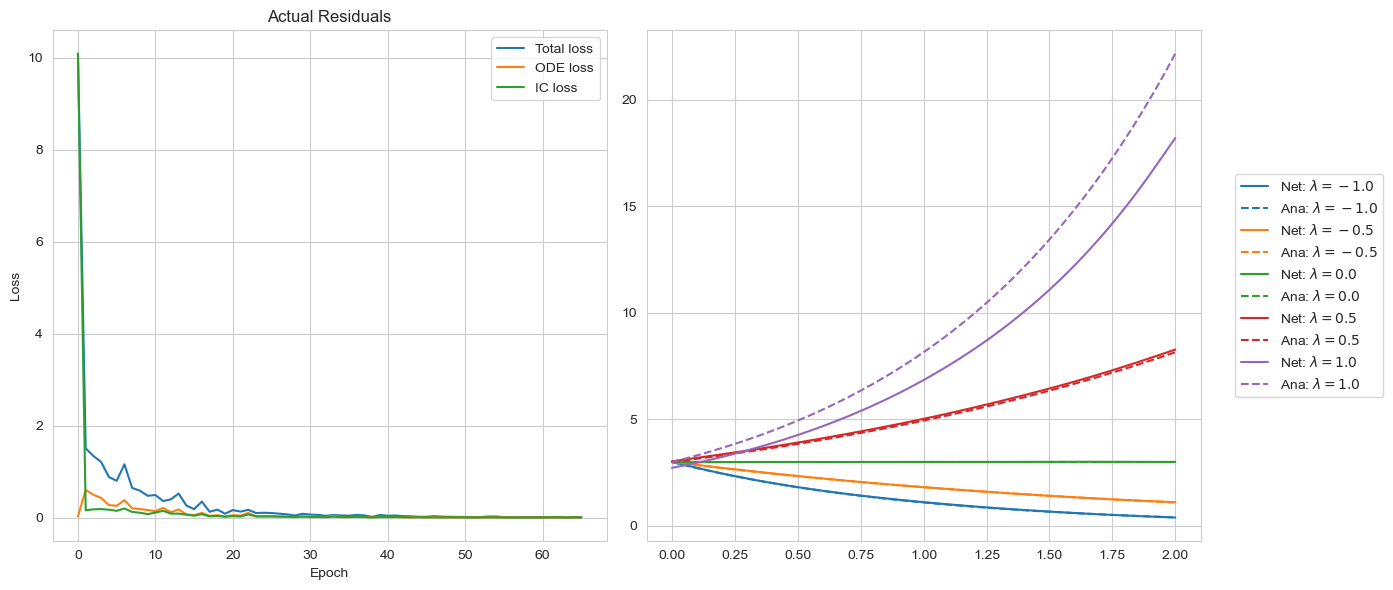

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
ax[0].plot(loss_saved, label='Total loss')
ax[0].plot(adapt_ode_loss_saved, label='ODE loss')
ax[0].plot(adapt_IC_loss_saved, label='IC loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Actual Residuals')

lambdas_to_test = [-1.0, -0.5, 0.0, 0.5, 1.0]
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for i_lambda, color in zip(lambdas_to_test, colors):
    t_lin = torch.linspace(0, 2.0, 100)
    lambdas = torch.ones_like(t_lin) * i_lambda
    t_lamb_lin = torch.column_stack((t_lin, lambdas))
    net_lin = net(t_lamb_lin)
    ax[1].plot(t_lin.detach().numpy(), net_lin.view(-1).detach().numpy(), 
               label=f'Net: $\lambda={i_lambda}$', linestyle='-', color=color)
    ax[1].plot(t_lin.detach().numpy(), u(t_lamb_lin[:,0], t_lamb_lin[:,1], u0).view(-1).detach().numpy(), 
               label=f'Ana: $\lambda={i_lambda}$', linestyle='--', color=color)
    ax[1].legend(loc='center left', bbox_to_anchor=(1.05,0.5))




plt.tight_layout()

In [18]:
# Conclusions:
# We seem to have a hard time getting the more extreme case at lambda=1 be in order.
# 2 Likely reasons:
# 1. When we train we train on the domain -1->1 so 1 is at the edge of the domain and unlikely to be trainedon.
# 2. Of course reason 1. would be the same for lambda=-1 but for lambda=-1 the change from -0.0->-0.5->-1.0 is pretty smooth and even.